# YZV202-E PROJECT 
## POST-EARTHQUAKE RELIEF DISTRIBUTION OPTIMIZATION USING GENETIC ALGORITHM AND PARTICLE SWARM OPTIMIZATION
### MUHAMMET SERDAR NAZLI 150210723
#### TEAM: InAkratic

In [1]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 


## GENETIC ALGORITHM

In [2]:
class DistributionGeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, num_generations, city_needs, city_supplies, route_costs,time_importance=10):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_generations = num_generations
        self.city_needs = city_needs
        self.city_supplies = city_supplies
        self.route_costs = route_costs
        self.time_coeff = time_importance

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = []
            for (source, dest), routes in self.route_costs.items():
                route = random.choice(list(routes.keys()))
                for resource_type in self.city_supplies[source]:
                    resource = random.randint(0, self.city_supplies[source][resource_type])
                    individual.append((source, dest, route, resource_type, resource))
            population.append(individual)
        return population

    def fitness_function(self, individual):
        total_cost = 0
        total_time = 0
        resources_transferred = {city: {resource_type: 0 for resource_type in needs} for city, needs in self.city_needs.items()}
        resources_used = {city: {resource_type: 0 for resource_type in supplies} for city, supplies in self.city_supplies.items()}

        for source, dest, route, resource_type, resource in individual:
            total_cost += self.route_costs[(source, dest)][route]['cost'] * resource
            total_time += self.route_costs[(source, dest)][route]["time"] * self.time_coeff
            resources_transferred[dest][resource_type] += resource
            resources_used[source][resource_type] += resource

        for city, needs in self.city_needs.items():
            for resource_type, need in needs.items():
                if resources_transferred[city][resource_type] < need:
                    total_cost += (need - resources_transferred[city][resource_type]) * 10000  # Penalty for not meeting needs

        for city, supplies in self.city_supplies.items():
            for resource_type, supply in supplies.items():
                if resources_used[city][resource_type] > supply:
                    total_cost += (resources_used[city][resource_type] - supply) * 10000  # Penalty for using more than available

        return -total_cost-total_time  # Negate because we want to minimize cost

    def selection(self, population, fitnesses):
            # Tournament selection
            selected = []
            for _ in range(len(population)):
                individuals = random.choices(population, k=3)
                fitnesses = [self.fitness_function(individual) for individual in individuals]
                selected.append(individuals[np.argmax(fitnesses)])
            return selected

    def crossover(self, parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(self, individual):
        index = random.randint(0, len(individual) - 1)
        source, dest, _, resource_type, _ = individual[index]
        route = random.choice(list(self.route_costs[(source, dest)].keys()))
        resource = random.randint(0, self.city_supplies[source][resource_type])
        individual[index] = (source, dest, route, resource_type, resource)
        return individual

    def run(self):
        population = self.initialize_population()

        best_fitnesses = []
        best_individuals = []

        for _ in range(self.num_generations):
            fitnesses = [self.fitness_function(individual) for individual in population]

            best_idx = np.argmax(fitnesses)
            best_fitnesses.append(fitnesses[best_idx])
            best_individuals.append(population[best_idx])
            
            parents = self.selection(population, fitnesses)

            new_population = []
            while len(new_population) < len(population):
                if random.random() < self.crossover_rate:
                    parent1 = random.choice(parents)
                    parent2 = random.choice(parents)
                    child1, child2 = self.crossover(parent1, parent2)
                    new_population.extend([child1, child2])
                else:
                    individual = random.choice(parents)
                    new_population.append(self.mutation(individual))

            population = new_population

        fitnesses = [self.fitness_function(individual) for individual in population]
        best_index = np.argmax(fitnesses)
        return population[best_index], best_fitnesses, best_individuals
    def print_plan(self, plan,mode=0):
        total_cost = 0
        total_time = 0
        for source, dest, route, resource_type, resource in plan:
            cost = self.route_costs[(source, dest)][route]["cost"] * resource
            time = self.route_costs[(source, dest)][route]["time"] 
            total_cost += cost
            total_time += time
            if not mode:
                print(f"Transport {resource}L of {resource_type} from {source} to {dest} using route {route} (Cost: {cost}, Time: {time})")
        print(f"Total cost: {total_cost}, Total time: {total_time}")


#### Example Usage of Genetic Algorithm

In [50]:
route_costs = {
    ("A", "C"): {"land": {"cost": 15, "time": 15}, "land": {"cost": 17, "time": 17}, "air": {"cost": 21, "time": 3}},
    ("A", "D"): {"land": {"cost": 16, "time": 16}},
    ("B", "C"): {"land": {"cost": 25, "time": 25}, "land": {"cost": 13, "time": 13}},
    ("B", "D"): {"land": {"cost": 14, "time": 14}, "air": {"cost": 18, "time": 2}},
}
city_needs = {"C": {"water": 150, "food": 100}, "D": {"water": 200, "food": 100}}
city_supplies = {"A": {"water": 250, "food": 200}, "B": {"water": 200, "food": 150}}
ga = DistributionGeneticAlgorithm(300, 0.1, 0.7, 300, city_needs, city_supplies, route_costs)
best_distribution_plan,fitness_hist_ga, individual_hist_ga = ga.run()
ga.print_plan(best_distribution_plan)


Transport 106L of water from A to C using route land (Cost: 1802, Time: 17)
Transport 31L of food from A to C using route air (Cost: 651, Time: 3)
Transport 118L of water from A to D using route land (Cost: 1888, Time: 16)
Transport 70L of food from A to D using route land (Cost: 1120, Time: 16)
Transport 44L of water from B to C using route land (Cost: 572, Time: 13)
Transport 69L of food from B to C using route land (Cost: 897, Time: 13)
Transport 82L of water from B to D using route land (Cost: 1148, Time: 14)
Transport 30L of food from B to D using route air (Cost: 540, Time: 2)
Total cost: 8618, Total time: 94


## Particle Swarm Optimization Algorithm

In [4]:
class DistributionParticleSwarmOptimization:
    def __init__(self, population_size, num_generations, city_needs, city_supplies, route_costs,c1=1,c2=2,effect_of_time=10):
        self.population_size = population_size
        self.num_generations = num_generations
        self.city_needs = city_needs
        self.city_supplies = city_supplies
        self.route_costs = route_costs
        self.c1 = c1
        self.c2 = c2
        self.global_best = None
        self.global_best_fitness = float('-inf')
        self.particles = self.initialize_population()
        self.time_coeff = effect_of_time

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = []
            for (source, dest), routes in self.route_costs.items():
                route = random.choice(list(routes.keys()))
                for resource_type in self.city_supplies[source]:
                    resource = random.randint(0, self.city_supplies[source][resource_type])
                    individual.append((source, dest, route, resource_type, resource))
            population.append({
                'position': individual,
                'best_position': individual[:],
                'velocity': [0 for _ in range(len(individual))],
                'best_fitness': float('-inf'),
            })
        return population

    def fitness_function(self, individual):
        total_cost = 0
        total_time = 0
        resources_transferred = {city: {resource_type: 0 for resource_type in needs} for city, needs in self.city_needs.items()}
        resources_used = {city: {resource_type: 0 for resource_type in supplies} for city, supplies in self.city_supplies.items()}

        for source, dest, route, resource_type, resource in individual:
            try:
                total_cost += self.route_costs[(source, dest)][route]['cost'] * resource
                total_time += self.route_costs[(source, dest)][route]["time"] * self.time_coeff
                resources_transferred[dest][resource_type] += resource
                resources_used[source][resource_type] += resource
            except:
                print(source,dest,route,resource)
                raise ValueError()
        for city, needs in self.city_needs.items():
            for resource_type, need in needs.items():
                if resources_transferred[city][resource_type] < need:
                    total_cost += (need - resources_transferred[city][resource_type]) * 10000  # Penalty for not meeting needs

        for city, supplies in self.city_supplies.items():
            for resource_type, supply in supplies.items():
                if resources_used[city][resource_type] > supply:
                    total_cost += (resources_used[city][resource_type] - supply) * 10000  # Penalty for using more than available

        return -total_cost-total_time  # Negate because we want to minimize cost
    
    def update_velocity(self, particle):
        for i in range(len(particle['velocity'])):
            r1 = random.random()
            r2 = random.random()

            cognitive_velocity = self.c1 * r1 * (particle['best_position'][i][4] - particle['position'][i][4])
            social_velocity = self.c2 * r2 * (self.global_best[i][4] - particle['position'][i][4])

            particle['velocity'][i] = cognitive_velocity + social_velocity

    def update_position(self, particle):
        for i in range(len(particle['position'])):
            source, dest, _, resource_type, _ = particle['position'][i]
            routes = list(self.route_costs[(source, dest)].keys())
            weights = [1 / self.route_costs[(source, dest)][route]['cost'] for route in routes]
            route = random.choices(routes, weights=weights, k=1)[0]
            resource = max(0, int(particle['position'][i][4] + particle['velocity'][i]))
            resource = min(resource, self.city_supplies[source][resource_type])
            particle['position'][i] = (source, dest, route, resource_type, resource)

    def run(self):

        best_fitnesses =[]
        for _ in range(self.num_generations):
            for particle in self.particles:
                fitness = self.fitness_function(particle['position'])
                
                if fitness > particle['best_fitness']:
                    particle['best_fitness'] = fitness
                    particle['best_position'] = particle['position'][:]

                if fitness > self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best = particle['position'][:]

                best_fitnesses.append(self.global_best_fitness)
            for particle in self.particles:
                self.update_velocity(particle)
                self.update_position(particle)



        return self.global_best, best_fitnesses

    def print_plan(self, plan,mode=0):
        total_cost = 0
        total_time = 0
        for source, dest, route, resource_type, resource in plan:
            cost = self.route_costs[(source, dest)][route]["cost"] * resource
            time = self.route_costs[(source, dest)][route]["time"] 
            total_cost += cost
            total_time += time
            if not mode:
                print(f"Transport {resource}L of {resource_type} from {source} to {dest} using route {route} (Cost: {cost}, Time: {time})")
        print(f"Total cost: {total_cost}, Total time: {total_time}")


### Example Usage of PSO

In [53]:

route_costs = {
    ("A", "C"): {"land": {"cost": 15, "time": 15}, "land": {"cost": 17, "time": 17}, "air": {"cost": 21, "time": 3.5}},
    ("A", "D"): {"land": {"cost": 16, "time": 16}},
    ("B", "C"): {"land": {"cost": 25, "time": 25}, "land": {"cost": 13, "time": 13}},
    ("B", "D"): {"land": {"cost": 14, "time": 14}, "air": {"cost": 18, "time": 2}},
}
city_needs = {"C": {"water": 150, "food": 100}, "D": {"water": 200, "food": 100}}
city_supplies = {"A": {"water": 250, "food": 200}, "B": {"water": 200, "food": 150}}

pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs)
best_distribution_plan,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan)

Transport 0L of water from A to C using route air (Cost: 0, Time: 3.5)
Transport 99L of food from A to C using route land (Cost: 1683, Time: 17)
Transport 180L of water from A to D using route land (Cost: 2880, Time: 16)
Transport 0L of food from A to D using route land (Cost: 0, Time: 16)
Transport 150L of water from B to C using route land (Cost: 1950, Time: 13)
Transport 1L of food from B to C using route land (Cost: 13, Time: 13)
Transport 20L of water from B to D using route air (Cost: 360, Time: 2)
Transport 100L of food from B to D using route land (Cost: 1400, Time: 14)
Total cost: 8286, Total time: 94.5


### Example Convergence Plot

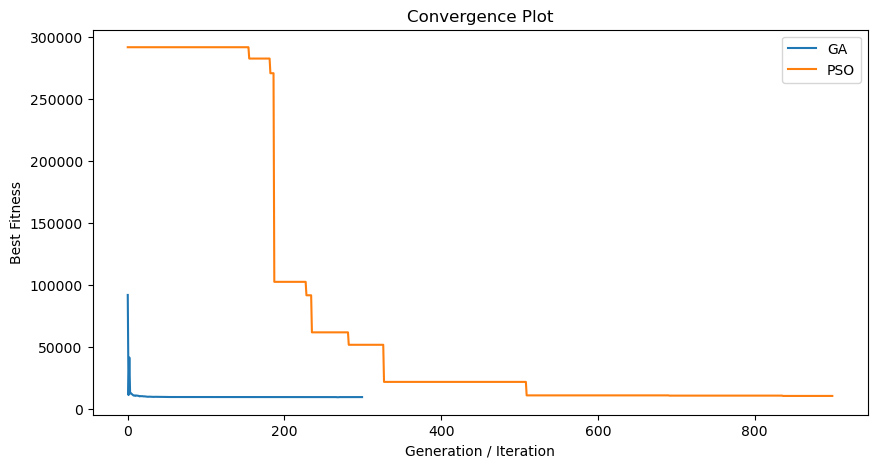

In [58]:
def converge_plot(fit_ga, fit_pso):
    # Convergence plot
    plt.figure(figsize=(10, 5))
    plt.plot(-np.array(fit_ga), label='GA')
    plt.plot(-np.array(fit_pso), label='PSO')
    plt.xlabel('Generation / Iteration')
    plt.ylabel('Best Fitness')
    plt.legend()
    plt.title('Convergence Plot')
    plt.show()

converge_plot(fitness_hist_ga[0:900],fitness_hist_pso[100:1000])

## REAL PROBLEM: POST-EARTHQUAKE RELIEF DISTRUBITION

### COSTS OF DIFFERENT ROUTES, DIFFERENT VARIABLES,  CITY NEEDS AND CITY SUPPLIES

In [7]:
#Gasoline consumption(GC) per kilometer and per unit for trucks in TL coefficient. 
gc = 6

#Average AIR transportation cost is 60.000 USD
air_usd = 60000
#USD/TL currency
currency = 20

air_cost = air_usd*currency
#https://www.kgm.gov.tr/Sayfalar/KGM/SiteTr/Uzakliklar/illerArasiMesafe.aspx
#https://web.archive.org/web/20230000000000*/https://www.kgm.gov.tr/Sayfalar/KGM/SiteTr/YolDanisma/TrafigeKapaliYollar.aspx
#https://www.google.com/maps
route_costs = {
    ("istanbul","hatay") : {"TRUCK(BOLU-ANKARA-ADANA)": {"cost":1109*gc, "time":15}, "TRUCK(BURSA-ESKISEHIR-)": {"cost":1148*gc,"time":17}},
    ("istanbul","gaziantep"): {"TRUCK(BOLU-ANKARA-ADANA)" :{"cost":1141*gc,"time":15},"TRUCK(BOLU-ANKARA-KAYSERI)":{"cost":1104*gc,"time":16}, "AIR": {"cost":air_cost*1,"time":1.5}},
    ("istanbul","sanliurfa"): {"TRUCK(BOLU-ANKARA-ADANA)":{"cost":1283*gc,"time":18}, "AIR": {"cost":air_cost*1,"time":1.5}},
    ("istanbul","maras"): {"TRUCK(BOLU-ANKARA-KAYSERI)":{"cost":1030*gc,"time":15},"AIR": {"cost":air_cost*1,"time":1.5}},
    ("istanbul", "adana"):{"TRUCK(BOLU-ANKARA-NIGDE)":{"cost":928*gc,"time":12}, "TRUCK(BURSA-ANKARA-NIGDE)":{"cost":967*gc,"time":14}, "AIR":{"cost":air_cost*1, "time":1.5}},
    ("istanbul","adiyaman"):{"TRUCK(BOLU-ANKARA-KAYSERI)":{"cost":1155*gc,"time":17},"AIR":{"cost":air_cost*1,"time":1.5}},
    ("istanbul","diyarbakir"):{"TRUCK(BOLU-ANKARA-KAYSERI)":{"cost":1336*gc,"time":18.5}, "AIR":{"cost":air_cost*1, "time":2}},
    ("istanbul","malatya"):{"TRUCK(BOLU-ANKARA-KAYSERI)":{"cost":1110*gc,"time":15}, "AIR":{"cost":air_cost*1,"time":1.5}}, 
    ("istanbul","kilis"):{"TRUCK(BOLU-ANKARA-KAYSERI)":{"cost":1173*gc, "time":16}},
    ("istanbul","osmaniye"):{"TRUCK(BOLU-ANKARA-ADANA)":{"cost":1015*gc, "time":14}},
    ("istanbul","elazig") : {"TRUCK(ANKARA-KAYSERI)": {"cost":1209*gc, "time":16},"AIR":{"cost":air_cost*1,"time":1.5}},

    ("ankara","hatay") : {"TRUCK(ADANA)":{"cost":680*gc,"time":10}},
    ("ankara","gaziantep"): {"TRUCK(ADANA)":{"cost":711*gc,"time":10}, "AIR":{"cost":air_cost*0.6,"time":1.1}},
    ("ankara","sanliurfa"): {"TRUCK(ADANA)":{"cost":854*gc, "time":11}, "TRUCK(MALATYA)":{"cost":904*gc,"time":11.4}, "AIR":{"cost":air_cost*0.6,"time":1.2}},
    ("ankara","maras"): {"TRUCK(KAYSERI)":{"cost":601*gc,"time":9.30}, "AIR":{"cost":air_cost*0.6,"time":1.1}},
    ("ankara", "adana"):{"TRUCK()":{"cost":499*gc,"time":7}, "AIR":{"cost":air_cost*0.6,"time":1}},
    ("ankara","adiyaman"):{"TRUCK(KAYSERI)":{"cost":820*gc,"time":12},"AIR":{"cost":air_cost*0.7,"time":1.2}},
    ("ankara","diyarbakir"):{"TRUCK(KAYSERI)":{"cost":908*gc,"time":13.5}, "AIR":{"cost":air_cost*0.6,"time":1.1}},
    ("ankara","malatya"):{"TRUCK(KAYSERI)":{"cost":681*gc,"time":10.5}, "AIR":{"cost":air_cost*0.6,"time":1.1}},
    ("ankara","kilis"):{"TRUCK(KAYSERI)":{"cost":745*gc,"time":11.5}},
    ("ankara","osmaniye"):{"TRUCK(OSMANIYE)":{"cost":587*gc,"time":8.5}},
    ("ankara","elazig"):{"TRUCK(KAYSERI)":{"cost":780*gc,"time":11}, "AIR":{"cost":air_cost*0.6,"time":1.2}},

    ("antalya","hatay") : {"TRUCK":{"cost":792,"time":12}},
    ("antalya","gaziantep"): {"TRUCK":{"cost":823*gc,"time":13},"AIR":{"cost":air_cost*0.6,"time":1.1}},
    ("antalya","sanliurfa"): {"TRUCK":{"cost":952*gc,"time":14},"AIR":{"cost":air_cost*0.7,"time":1.3}},
    ("antalya","maras"): {"TRUCK":{"cost":796*gc,"time":12}, "AIR":{"cost":air_cost*0.6,"time":1.2}},
    ("antalya", "adana"):{"TRUCK":{"cost":598*gc,"time":10}, "AIR":{"cost":air_cost*0.6,"time":1}},
    ("antalya","adiyaman"):{"TRUCK":{"cost":932*gc,"time":14},"AIR":{"cost":air_cost*0.7,"time":1.4}},
    ("antalya","diyarbakir"):{"TRUCK(MALATYA)":{"cost":1142*gc,"time":17},"AIR":{"cost":air_cost*0.7,"time":1.3}},
    ("antalya","malatya"):{"TRUCK(KAYSERI)":{"cost":915*gc,"time":14}, "AIR":{"cost":air_cost*0.7,"time":1.3}},
    ("antalya","kilis"):{"TRUCK":{"cost":877*gc,"time":13}},
    ("antalya","osmaniye"):{"TRUCK":{"cost":699*gc,"time":11}},
    ("antalya","elazig"):{"TRUCK(MALATYA)":{"cost":1014*gc,"time":18},"TRUCK(SIVAS)":{"cost":1028*gc,"time":15}}

    }

# according to the number of houses damaged(source: Strateji ve Bütçe Başkanlığı '2023' Kahramanmaraş ve Hatay Depremleri raporu);

# extreme coefficient. (Where the earthquake is much more severe and has more devastating consequences. (e.g. hatay,antep,maraş...))
e = 3
# hard coefficient. (Where the earthquake is less severe and has less devastating consequences(relatively) (e.g. diyarbakir...))
h = 1

"""Population of provinces (as units)
Adana:      220 
Adiyaman:   70
Diyarbakir: 180
Gaziantep:  210
Hatay:      160
Maras:      170
Kilis:      10
Osmaniye:   56
Malatya:    80
Sanliurfa:  210
Elazig:     59
"""

city_needs = {"hatay":    {"water": 160*e, "food": 160*e, "petrol": 160*e*1.5, "medicine":160*e},
            "gaziantep":  {"water": 210*e, "food": 210*e, "petrol":210*e*1.5, "medicine":160*e},
            "sanliurfa":  {"water": 210*e, "food": 210*e, "petrol":210*e*1.5, "medicine":160*e},
            "maras":      {"water": 170*e, "food": 170*e, "petrol":170*e*1.5, "medicine":170*e},
            "adana":      {"water": 220*h, "food": 220*h, "petrol":220*h, "medicine":220*h},
            "adiyaman":   {"water": 70*e, "food": 70*e, "petrol":70*e*1.5, "medicine":70*e},
            "diyarbakir": {"water": 180*h, "food": 180*h, "petrol":180*h, "medicine":180*h},
            "malatya":    {"water": 80*e, "food": 80*e, "petrol":80*e*1.5, "medicine":80*e},
            "kilis":      {"water": 10*e, "food": 10*e, "petrol":10*e*1.5, "medicine":10*e},
            "osmaniye":   {"water": 56*e, "food": 56*e, "petrol":56*e*1.5, "medicine":56*e},
            "elazig":     {"water": 59*h, "food": 59*h, "petrol":59*h, "medicine":59*h}
              }

#ISTANBUL WATER AVAILABILITY
#https://www.aski.gov.tr/tr/baraj.aspx
#ANKARA WATER AVAILABILITY
#https://www.iski.istanbul/web/tr-TR/baraj-doluluk
#ANTALYA WATER AVAILABILITY
# http://web.archive.org/web/20230000000000*/https://seffaflik.epias.com.tr/transparency/barajlar/aktif-doluluk.xhtml

#FOOD ASSUMPTION: EACH DISTRUBITUION CENTER HAS THE SAME AMOUNT OF FOOD. 

#PETROL         : ASSUMPTION, BECAUSE OF KIRIKKALE ANKARA HAS MORE PETROL RESERVE

#MEDICINE       : https://hipokratist.com/tum-ecza-depolari/



city_supplies = {"istanbul":  {"water": 2500, "food":4000, "petrol":1000 ,"medicine":2500}, 
                 "ankara":    {"water": 350,  "food":4000, "petrol":3000 ,"medicine":1300},
                 "antalya":   {"water":1250,  "food":4000, "petrol":900 ,"medicine":500}

                 }


In [8]:
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,3,7)
best_distribution_plan,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan,mode=1)

Total cost: 248377500, Total time: 1688.1


In [9]:
ga = DistributionGeneticAlgorithm(300, 0.1, 0.7, 300, city_needs, city_supplies, route_costs)
best_distribution_plan,fitness_hist_ga, individual_hist_ga = ga.run()
ga.print_plan(best_distribution_plan,mode=1)

Total cost: 94539786.0, Total time: 1718.1


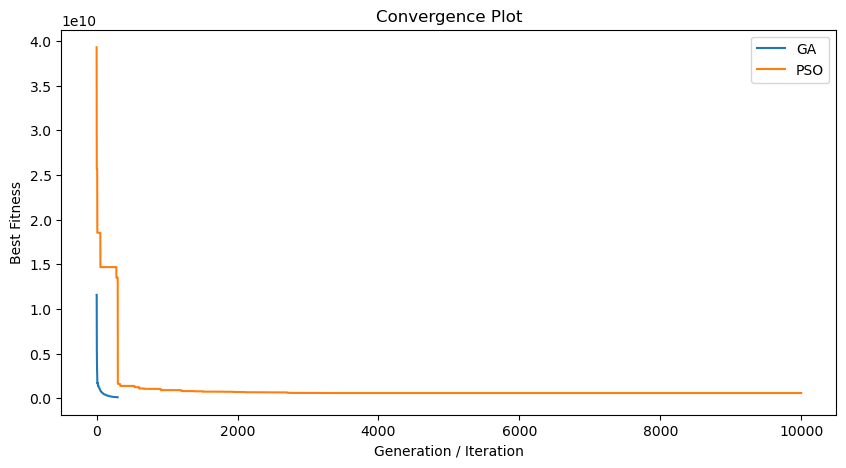

In [10]:

converge_plot(fitness_hist_ga[:10000],fitness_hist_pso[0:10000])


In [11]:
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,1,5)
best_distribution_plan,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan,mode=1)

Total cost: 329479500.0, Total time: 1675.1999999999998


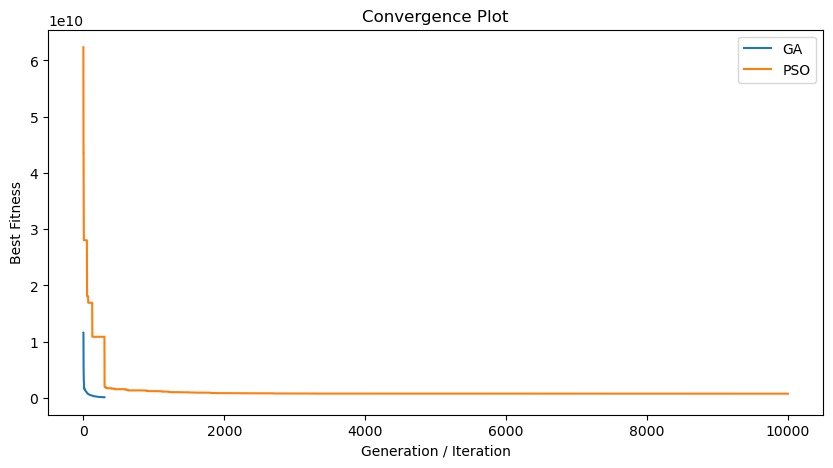

In [12]:
converge_plot(fitness_hist_ga[:10000],fitness_hist_pso[0:10000])

Total cost: 297115500.0, Total time: 1693.6999999999996


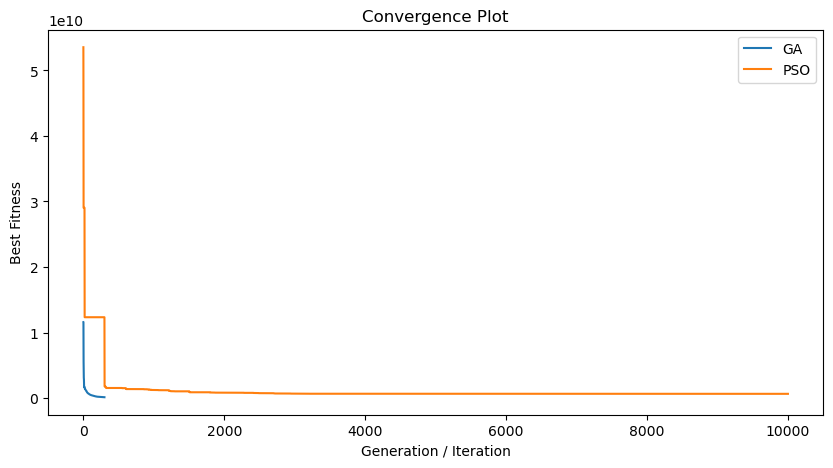

In [13]:
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,7,5)
best_distribution_plan,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan,mode=1)
converge_plot(fitness_hist_ga[:10000],fitness_hist_pso[0:10000])

Total cost: 224632800.0, Total time: 1669.1


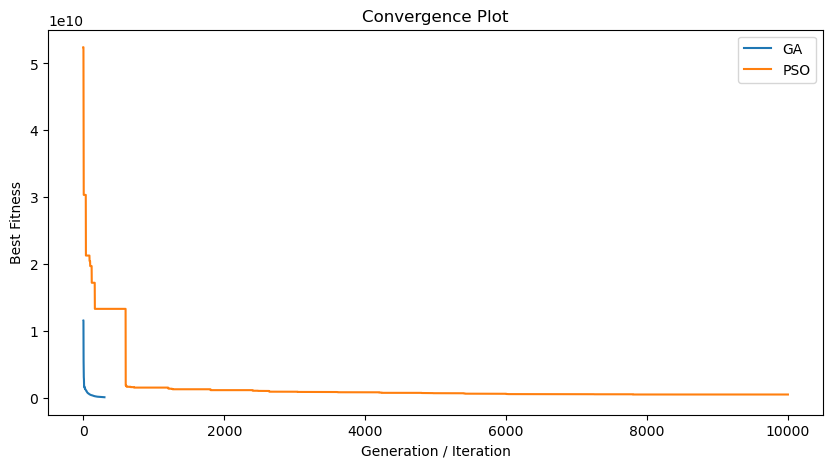

In [14]:
pso = DistributionParticleSwarmOptimization(600, 600, city_needs, city_supplies, route_costs,7,5)
best_distribution_plan,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan,mode=1)
converge_plot(fitness_hist_ga[:10000],fitness_hist_pso[0:10000])

Total cost: 64906242, Total time: 1746.3999999999996


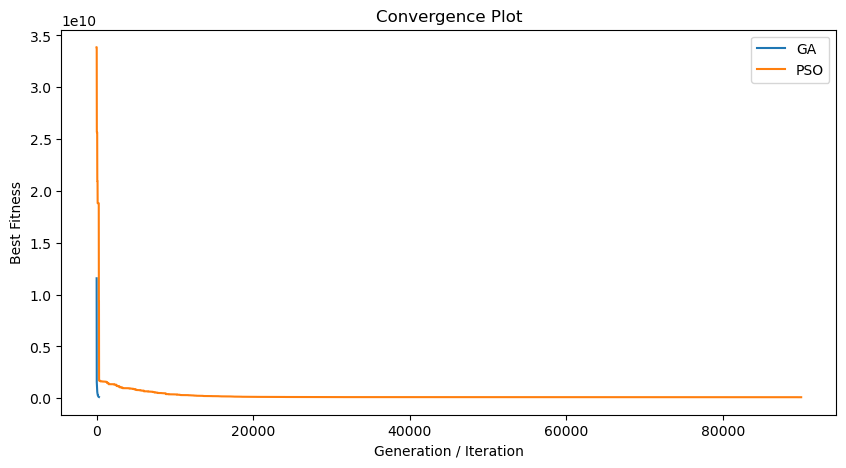

In [15]:
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,5,1)
best_distribution_plan,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan,mode=1)
converge_plot(fitness_hist_ga,fitness_hist_pso)

Tried to find best parameter for PSO. 

# How many air vehicles are used?

Total cost: 60482472, Total time: 1741.9999999999998
Total cost: 99861672, Total time: 1741.3999999999996


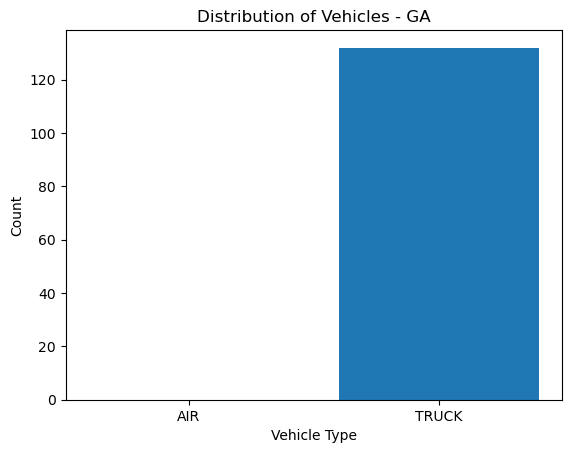

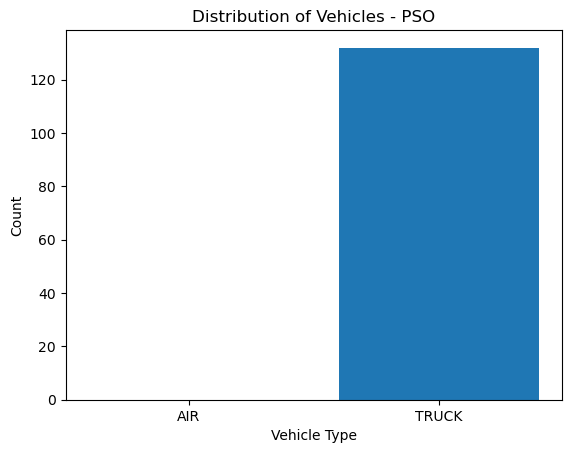

In [16]:
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,5,1)
best_distribution_plan_pso,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan_pso,mode=1)


ga = DistributionGeneticAlgorithm(300, 0.1, 0.7, 300, city_needs, city_supplies, route_costs)
best_distribution_plan_ga,fitness_hist_ga, individual_hist_ga = ga.run()
ga.print_plan(best_distribution_plan_ga,mode=1)


def count_air_vehicles(output):
    air_count = 0
    for item in output:
        if 'AIR' in item[2]: 
            air_count += 1
    return air_count

def plot_air_vehicles(air_count,plan,label=""):
    plt.bar(['AIR', 'TRUCK'], [air_count, len(plan) - air_count])
    plt.title(f'Distribution of Vehicles - {label}')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Count')
    plt.show()

ga_air_vehicles_count = count_air_vehicles(best_distribution_plan_ga)
pso_air_vehicles_count = count_air_vehicles(best_distribution_plan_pso)

plot_air_vehicles(ga_air_vehicles_count,best_distribution_plan_ga,label="GA")
plot_air_vehicles(pso_air_vehicles_count, best_distribution_plan_pso,label="PSO")


## EFFECT OF TIME

In [24]:
#PSO but effect of time is increased by 10000
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,5,1,effect_of_time=10000)
best_distribution_plan_pso,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan_pso,mode=1)


#GA but effect of time is increased by 10000
ga2 = DistributionGeneticAlgorithm(300, 0.1, 0.7, 300, city_needs, city_supplies, route_costs,time_importance=10000)
best_distribution_plan_ga2,fitness_hist_ga, individual_hist_ga = ga2.run()
ga2.print_plan(best_distribution_plan_ga2,mode=1)


Total cost: 60457350, Total time: 1731.9999999999998
Total cost: 94122606.0, Total time: 1731.6


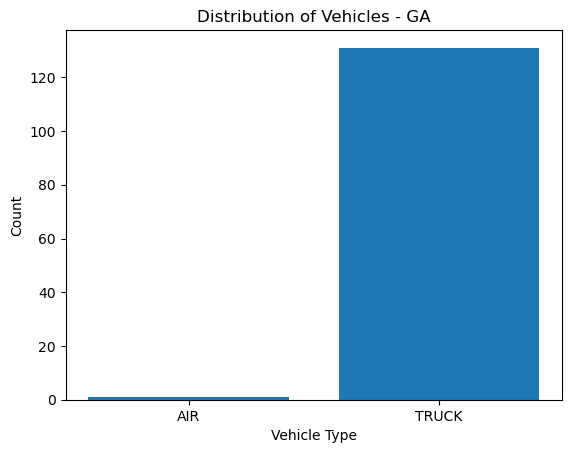

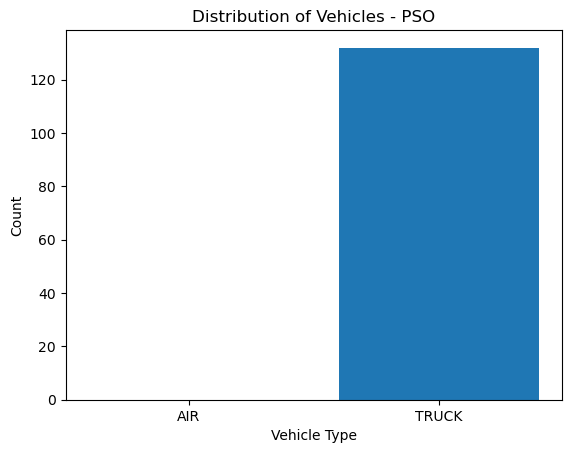

In [25]:
ga_air_vehicles_count = count_air_vehicles(best_distribution_plan_ga2)
pso_air_vehicles_count = count_air_vehicles(best_distribution_plan_pso)

plot_air_vehicles(ga_air_vehicles_count,best_distribution_plan_ga2,label="GA")
plot_air_vehicles(pso_air_vehicles_count, best_distribution_plan_pso,label="PSO")

Total cost: 57446154.0, Total time: 1713.8999999999999
Total cost: 87639624.0, Total time: 1727.2999999999997


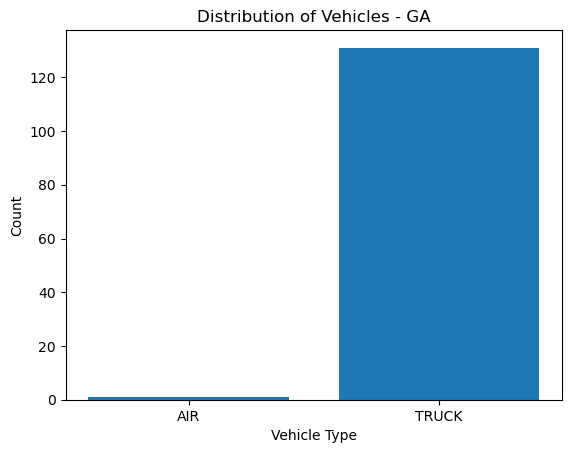

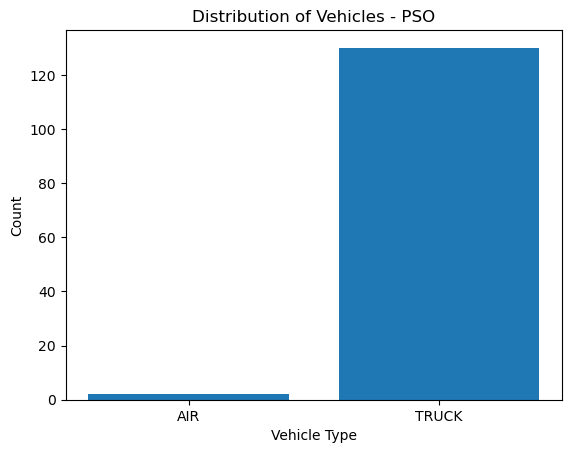

In [26]:
#PSO but effect of time is increased by 100000
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,5,1,effect_of_time=100000)
best_distribution_plan_pso,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan_pso,mode=1)


#GA but effect of time is increased by 100000
ga2 = DistributionGeneticAlgorithm(300, 0.1, 0.7, 300, city_needs, city_supplies, route_costs,time_importance=100000)
best_distribution_plan_ga2,fitness_hist_ga, individual_hist_ga = ga2.run()
ga2.print_plan(best_distribution_plan_ga2,mode=1)

ga_air_vehicles_count = count_air_vehicles(best_distribution_plan_ga2)
pso_air_vehicles_count = count_air_vehicles(best_distribution_plan_pso)

plot_air_vehicles(ga_air_vehicles_count,best_distribution_plan_ga2,label="GA")
plot_air_vehicles(pso_air_vehicles_count, best_distribution_plan_pso,label="PSO")

Total cost: 86081994.0, Total time: 1707.0999999999997
Total cost: 102187218.0, Total time: 1680.8999999999999


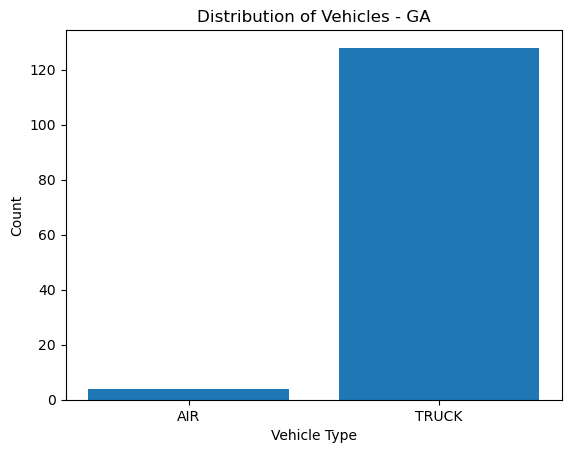

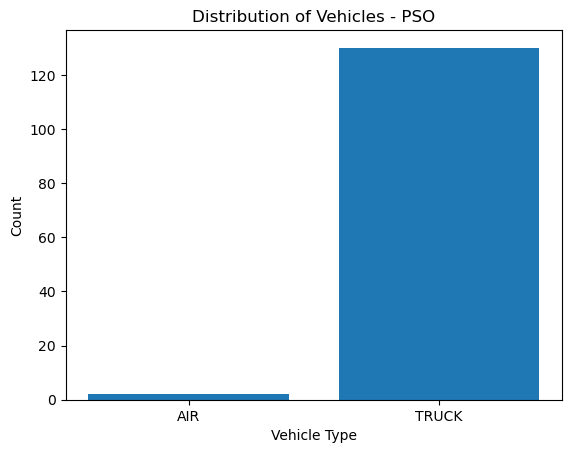

In [44]:
#PSO but effect of time is increased by 1000000
pso = DistributionParticleSwarmOptimization(300, 300, city_needs, city_supplies, route_costs,5,1,effect_of_time=500000)
best_distribution_plan_pso,fitness_hist_pso = pso.run()
pso.print_plan(best_distribution_plan_pso,mode=1)


#GA but effect of time is increased by 1000000
ga2 = DistributionGeneticAlgorithm(300, 0.1, 0.7, 300, city_needs, city_supplies, route_costs,time_importance=300000)
best_distribution_plan_ga2,fitness_hist_ga, individual_hist_ga = ga2.run()
ga2.print_plan(best_distribution_plan_ga2,mode=1)

ga_air_vehicles_count = count_air_vehicles(best_distribution_plan_ga2)
pso_air_vehicles_count = count_air_vehicles(best_distribution_plan_pso)

plot_air_vehicles(ga_air_vehicles_count,best_distribution_plan_ga2,label="GA")
plot_air_vehicles(pso_air_vehicles_count, best_distribution_plan_pso,label="PSO")

In [45]:
ga.print_plan(best_distribution_plan_ga)

Transport 298L of water from istanbul to hatay using route TRUCK(BURSA-ESKISEHIR-) (Cost: 2052624, Time: 17)
Transport 10L of food from istanbul to hatay using route TRUCK(BURSA-ESKISEHIR-) (Cost: 68880, Time: 17)
Transport 1L of petrol from istanbul to hatay using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 6654, Time: 15)
Transport 359L of medicine from istanbul to hatay using route TRUCK(BURSA-ESKISEHIR-) (Cost: 2472792, Time: 17)
Transport 485L of water from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 3320310, Time: 15)
Transport 27L of food from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 184842, Time: 15)
Transport 63L of petrol from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 431298, Time: 15)
Transport 223L of medicine from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 1526658, Time: 15)
Transport 266L of water from istanbul to sanliurfa using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 2047668, Time: 18)

In [46]:
ga2.print_plan(best_distribution_plan_ga2)

Transport 375L of water from istanbul to hatay using route TRUCK(BURSA-ESKISEHIR-) (Cost: 2583000, Time: 17)
Transport 27L of food from istanbul to hatay using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 179658, Time: 15)
Transport 262L of petrol from istanbul to hatay using route TRUCK(BURSA-ESKISEHIR-) (Cost: 1804656, Time: 17)
Transport 168L of medicine from istanbul to hatay using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 1117872, Time: 15)
Transport 449L of water from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-KAYSERI) (Cost: 2974176, Time: 16)
Transport 0L of food from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-KAYSERI) (Cost: 0, Time: 16)
Transport 172L of petrol from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 1177512, Time: 15)
Transport 353L of medicine from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 2416638, Time: 15)
Transport 275L of water from istanbul to sanliurfa using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 2116950, Ti

In [47]:
pso.print_plan(best_distribution_plan_pso)

Transport 0L of water from istanbul to hatay using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 0, Time: 15)
Transport 59L of food from istanbul to hatay using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 392586, Time: 15)
Transport 30L of petrol from istanbul to hatay using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 199620, Time: 15)
Transport 26L of medicine from istanbul to hatay using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 173004, Time: 15)
Transport 189L of water from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 1293894, Time: 15)
Transport 536L of food from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-KAYSERI) (Cost: 3550464, Time: 16)
Transport 0L of petrol from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 0, Time: 15)
Transport 108L of medicine from istanbul to gaziantep using route TRUCK(BOLU-ANKARA-KAYSERI) (Cost: 715392, Time: 16)
Transport 31L of water from istanbul to sanliurfa using route TRUCK(BOLU-ANKARA-ADANA) (Cost: 238638, Time: 18)
Trans